In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from patsy import dmatrices
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

### Detekcja obserwacji odstających:

1. **Wykres studentyzowanych rezyduów**

Dla małych prób, wartości zmiennej objaśniającej nie są w miarę równomiernie rozłożone i niektóre błędy $\text{SE}(e_i)$ mogą znacznie odbierać od błędu $S$. Wówczas dobrze jest analizować rezydua przy użyciu tzw. **rezyduów studentyzowanych**.

$$r_i =\frac{e_i}{\text{SE}(e_i)}$$

To pozwoli wykrywać obserwacje faktycznie odstające, pomijając te, które przy analizie rezyduów $e_i$ sugerowały, że są odstające mimo, że takimi nie były. Dla rezyduów studentyzowanych zakłada się, że przy poziomie ufności równym 0.95 uznaje się je za normalne (zachowujące własność rozkładu normalnego), gdy należą do przedziału $[−2,+2]$.

Wykres studentyzowanych rezyduów względem ich indeksu identyfikuje duże wartości, które przypuszczalnie odpowiadają obserwacjom odstającym. Metodata nie sprawdzi się w sytuacji, gdy mamy w analizowanym zbiorze obserwację wpływową o małej wartości $e_i$. Wówczas bowiem nie określimy jej jako odstającej mimo, że taka w istocie jest.

2. **Wpływowość**

Wpływ $i$-tej obserwacji $h_i$ określamy wzorem
$$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2},
$$
który określa odstępstwo $x_i$ od $\overline{x}$.

Dla modelu o $p$ parametrach (gdzie $p$ to łączna liczba zmiennych objaśniających i objaśnianych), obserwację uznajemy za wpływową jeśli
$$
h_i \geq \frac{2p}{n}.
$$

3. **Odległość Cooka**

Jest to miara stopnia zmiany współczynników regresji, gdyby dany przypadek pominąć w obliczeniach współczynników:
$$
D_i = \frac{\sum_{j=1}^n(\hat{Y}_j - \hat{Y}_{j(i)})^2}{pS^2},
$$
gdzie $\hat{Y}_j$ - prognoza na podstawie pełnych danych, $\hat{Y}_{j(i)}$ - prognoza bez $i$-tej obserwacji.

**Interpretacja**: Duża wartość $D_i$ wskazuje na znaczy wpływ usunięcia $i$-tej obserwacji, czyli $i$-ta obserwacja jest obserwacją wpływową.

Wszystkie wartości dla danej odległości powinny być tego samego rzędu. Jeśli tak nie jest, to prawdopodobnie dany przypadek ma istotnie duży wpływ na obciążenie równania regresji.

**Reguła kciuka**: $D_i > \frac{4}{(n − p − 1)}$

# Zadanie 1

Wczytaj zbiór `Carseats`, który zawierają dane o sprzedaży fotelików samochodowych pewnej firmy w 400 różnych lokalizacjach:

• sprzedaż jednostek (w tysiącach) w danej lokalizacji (`Sales`),

• cena sprzedaży konkurenta w danej lokalizacji (`CompPrice`),

• poziom dochodów społeczności wdanej lokalizacji w tys. dolarów (`Income`),

• wielkość populacji w danym regionie (`Population`),

• lokalny budżet reklamowy dla firmy w danej lokalizacji (`Advertising`),

• cena sprzedaży w danej lokalizacji (`Price`),

• na ile korzystne jest miejsce na półkach sklepu dla fotelików w danym regionie?
(`Shelveloc`),

• średni wiek ludności lokalnej (`Age`),

• poziom wykształcenia w każdej lokalizacji (`Education`),

• czy położenie sklepu jest w lokalizacji miejskiej? (`Urban`)

• czy sklep znajduje się w USA? (`US`)

1. Wyznacz model liniowy najlepiej opisujący zależność sprzedaży fotelików samochodowych od pozostałych dostępnych zmiennych.

2. Zidentyfikuj obserwacje odstające w modelu.

3. Zidentyfikuj obserwacje wpływowe.

In [3]:
carseats = sm.datasets.get_rdataset(dataname="Carseats", package="ISLR", cache=True)
columns = list(carseats.data.columns)
columns.remove('Sales')
features = "+".join(columns)

model = smf.ols('Sales ~ ' + features, data=carseats.data)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     243.4
Date:                Sat, 07 Jun 2025   Prob (F-statistic):          1.60e-166
Time:                        13:25:29   Log-Likelihood:                -568.99
No. Observations:                 400   AIC:                             1162.
Df Residuals:                     388   BIC:                             1210.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.6606      0.603      9.380      0.000       4.474       6.847
ShelveLoc[T.Good]       4.8502      0.153     31.678      0.000       4.549       5.151
ShelveLoc[T.Medium]     1.9567      0.126     15.516      0.000       1.709       2.205
Urban[T.Yes]            0.1229      0.113      1.088      0.277      -0.099       0.345
US[T.Yes]              -0.1841      0.150     -1.229      0.220      -0.479       0.111
CompPrice               0.0928      0.004     22.378      0.000       0.085       0.101
Income                  0.0158      0.002      8.565      0.000       0.012       0.019
Advertising             0.1231      0.011     11.066      0.000       0.101       0.145
Population              0.0002      0.000      0.561      0.575      -0.001       0.001
Price                  -0.0954      0.003    -35.700      0.000      -0.101      -0.090
Age                    -0.0460      0.003    -14.472      0.000      -0.052      -0.040
Education              -0.0211      0.020     -1.070      0.285      -0.060       0.018
==============================================================================
Omnibus:                        0.811   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.667   Jarque-Bera (JB):                0.765
Skew:                           0.107   Prob(JB):                        0.682
Kurtosis:                       2.994   Cond. No.                     4.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
h = fitted_model.get_influence()
h.resid_studentized

array([ 2.24252234, -1.19294915,  0.7673699 , -1.10096644, -1.92751846,
        1.1385529 ,  0.42882349,  0.3002147 ,  0.44537056, -1.12713069,
        0.87498929,  0.10864812,  0.23732197, -0.94598368,  1.5812939 ,
        2.68280493, -0.90056957,  0.46918652,  0.51731325,  0.97997718,
       -0.00947193,  1.00786336, -0.7366876 ,  0.58807835,  0.13356578,
        1.49165942, -0.17647458,  0.07418664, -1.39637616,  1.8461038 ,
       -0.14267775,  0.03222147,  0.13257894,  0.31652513, -2.00089648,
        0.32832437, -1.51799084, -1.98425367,  0.51658082, -0.34468259,
       -0.45424237,  1.51543928, -0.5904213 , -1.096305  , -0.82713855,
       -0.00433115, -0.73024826, -1.50174549, -0.62928836, -0.03555808,
       -1.84576605,  0.04180425,  1.56194506,  1.13544465, -0.61468275,
        1.97628987,  1.18367665, -0.10643179,  0.47043461, -0.29643053,
        0.68545345,  1.04887437, -0.83534378, -0.07289291,  0.23833471,
        0.51605326, -0.60087042,  0.50216278,  1.29443813,  0.14

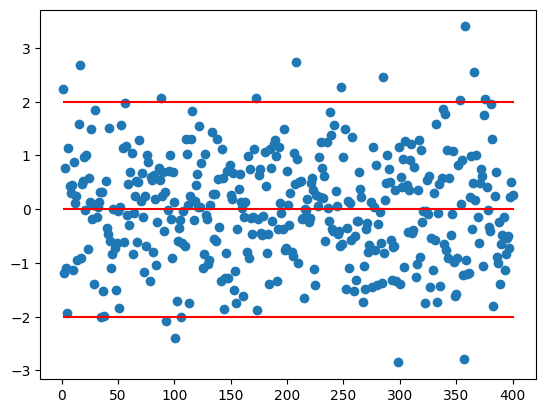

In [5]:
#wartości odstające
x = np.arange(1, h.resid_studentized.size + 1)
plt.scatter(x=x, y=h.resid_studentized)
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=-2, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=0, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=2, color="r")
#te poza pasem kwalifikujemy jako do usunięcia

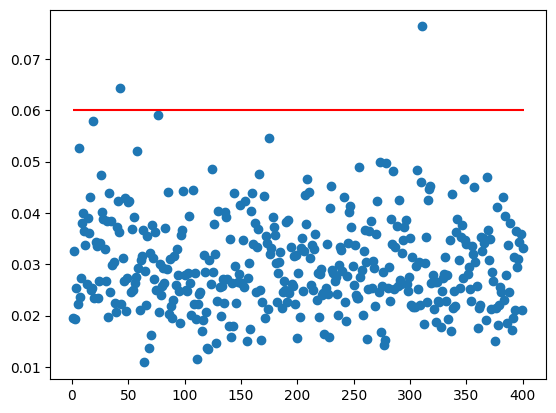

In [6]:
#wartości wpływowe h_i
h.hat_matrix_diag
threshold = 2*h.exog.shape[1]/h.exog.shape[0]

x = np.arange(1, h.hat_matrix_diag.size + 1)
plt.scatter(x=x, y=h.hat_matrix_diag)
plt.hlines(xmin=1, xmax=h.hat_matrix_diag.size + 1, y=threshold, color="r")
#są dwie obs wpływowe

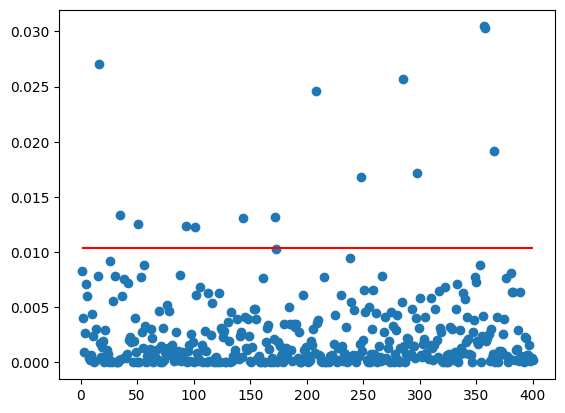

In [7]:
#obserwacje wpływowe odległości cooka (inna metoda detekcji wpływowości)
threshold = 4/(h.exog.shape[0]-h.exog.shape[1]-1)
h.cooks_distance
x = np.arange(1, h.cooks_distance[0].size + 1)
plt.scatter(x=x, y=h.cooks_distance[0])
plt.hlines(xmin=1, xmax = x[-1], y = threshold, color='r')

# Zadanie 2
Wczytaj dane `pollution.csv` (opis danych: https://www.rdocumentation.org/packages/SMPracticals/versions/1.4-3/topics/pollution). Dopasuj model regresji liniowej postaci: `mort~nox`.
1. Czy model jest dobrze dopasowany do danych? Jeżeli nie, dlaczego?
2. Dokonaj logarytmicznego przekształcenia zmiennej objaśniającej. Jak mocno poprawia się współczynnik $R^2$?
3. Dla przekształconego modelu usuń obserwacje odstające. Jak mocno poprawia się współczynnik $R^2$?

<ipython-input-8-cf3fd9f53785>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(X_plot,X_plot*fitted_model.params[1]+fitted_model.params[0],color = 'red')


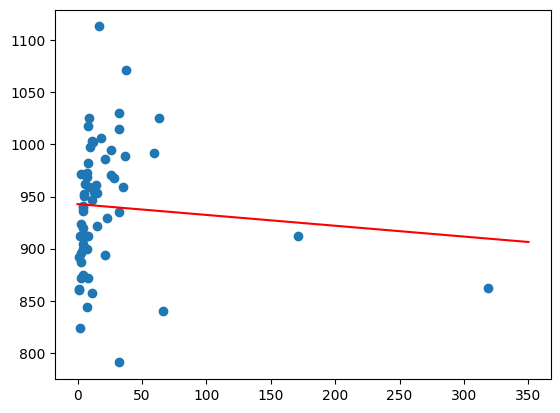

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mort   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.3494
Date:                Sat, 07 Jun 2025   Prob (F-statistic):              0.557
Time:                        13:26:00   Log-Likelihood:                -332.28
No. Observations:                  60   AIC:                             668.6
Df Residuals:                      58   BIC:                             672.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    942.7115      9.003    104.706      0.000     924.689     960.734
nox           -0.1039      0.176     -0.591      0.557      -0.456       0.248
==============================================================================
Omnibus:                        0.438   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.148
Skew:                           0.115   Prob(JB):                        0.929
Kurtosis:                       3.079   Cond. No.                         57.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
pollution = pd.read_csv("pollution.csv")
model = smf.ols('mort ~ nox', data=pollution)
fitted_model = model.fit()

plt.scatter(pollution['nox'],pollution['mort'])
X_plot = np.linspace(0,350,350)
plt.plot(X_plot,X_plot*fitted_model.params[1]+fitted_model.params[0],color = 'red')
plt.show()
fitted_model.summary()
#model kompletnie źle dopasowany, wina kilku obserwacji

<ipython-input-9-4e117666a918>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(X_plot,X_plot*fitted_model2.params[1]+fitted_model2.params[0],color = 'red')


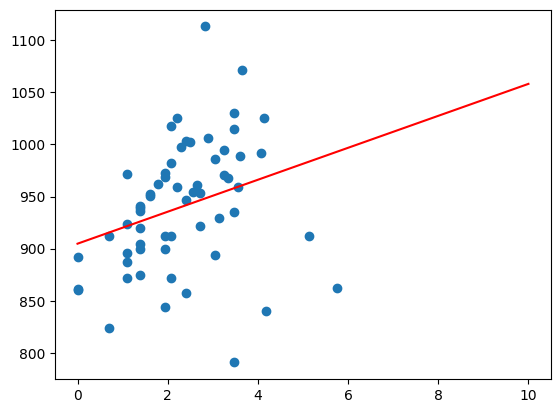

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mort   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.406
Date:                Sat, 07 Jun 2025   Prob (F-statistic):             0.0236
Time:                        13:26:02   Log-Likelihood:                -329.79
No. Observations:                  60   AIC:                             663.6
Df Residuals:                      58   BIC:                             667.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     904.7245     17.173     52.684      0.000     870.350     939.099
np.log(nox)    15.3355      6.596      2.325      0.024       2.133      28.538
==============================================================================
Omnibus:                        3.073   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.270
Skew:                          -0.285   Prob(JB):                        0.321
Kurtosis:                       3.764   Cond. No.                         6.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
model2 = smf.ols('mort ~ np.log(nox)', data=pollution)
fitted_model2 = model2.fit()

plt.scatter(np.log(pollution['nox']),pollution['mort'])
X_plot = np.linspace(0,10,350)
plt.plot(X_plot,X_plot*fitted_model2.params[1]+fitted_model2.params[0],color = 'red')
plt.show()
fitted_model2.summary()

#używamy przekształcenia logarytmicznego, dopasowanie jest lepsze, ale prosta jest wciąż ściągana przez punkty na dole

In [10]:
h = fitted_model2.get_influence()
np.where(np.abs(h.resid_studentized)>2)[0]
#te obserwacje są odstające

array([28, 36, 46, 48])

<ipython-input-11-d2e631cf9b61>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(X_plot,X_plot*fitted_model2.params[1]+fitted_model2.params[0],color = 'green')
<ipython-input-11-d2e631cf9b61>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(X_plot,X_plot*fitted_model3.params[1]+fitted_model3.params[0],color = 'red')


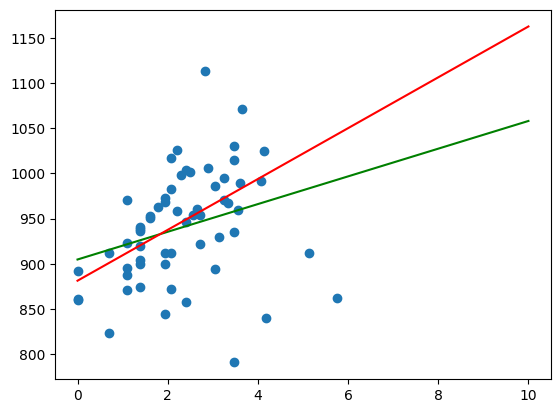

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mort   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     25.78
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           4.87e-06
Time:                        13:26:06   Log-Likelihood:                -291.23
No. Observations:                  56   AIC:                             586.5
Df Residuals:                      54   BIC:                             590.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     881.2501     13.574     64.922      0.000     854.036     908.464
np.log(nox)    28.1420      5.542      5.078      0.000      17.030      39.254
==============================================================================
Omnibus:                        1.663   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.435   Jarque-Bera (JB):                1.344
Skew:                          -0.379   Prob(JB):                        0.511
Kurtosis:                       2.954   Cond. No.                         6.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
pollution2 = pollution.copy()
pollution2 = pollution2.drop(pollution2.index[np.where(np.abs(h.resid_studentized)>2)[0]]) #usuwamy obserwacje odstające
model3 = smf.ols('mort ~ np.log(nox)', data=pollution2) #nowy model na zbiorze bez obs. odstających
fitted_model3 = model3.fit()
plt.scatter(np.log(pollution['nox']),pollution['mort'])
X_plot = np.linspace(0,10,350)
plt.plot(X_plot,X_plot*fitted_model2.params[1]+fitted_model2.params[0],color = 'green')
plt.plot(X_plot,X_plot*fitted_model3.params[1]+fitted_model3.params[0],color = 'red')
plt.show()
fitted_model3.summary()
#prosta bardziej zadarta, lepiej opisuje większość punktów, R^2 zwiększa się 4 razy

# Zadanie 3

1. Wczytać dane `realest.csv`, które zawierają informacje na temat domów na przedmieściach Chicago: cena domu (`Price`), liczba sypialni (`Bedroom`), powierzchnia w stopach kwadratowych (`Space`), liczba pokoi (`Room`), szerokość frontu działki w stopach (`Lot`), roczny podatek od nieruchomości (`Tax`), liczba łazienek (`Bathroom`), liczba miejsc parkingowych w garażu (`Garage`) i stan domu (`Condition`, 0-dobry, 1-wymaga remontu).

2. Podziel zbiór na część treningową i testową w stosunku 7:3.

3. Wyznacz model liniowy na danych treningowych najlepiej opisujący zależność ceny domu od pozostałych zmiennych w zbiorze. Oblicz $R^2$ tego modelu.

4. Znajdź obserwacje wpływowe w modelu i usuń je. Dopasuj model bez tych obserwacji. Oblicz $R^2$ tego modelu.

5. Znajdź obserwacje odstające w nowym modelu i usuń je. Dopasuj nowy model. Oblicz $R^2$ tego modelu.

6. Oblicz miary MSE i MAE dla zbioru testowego. Dodaj do zbioru testowego obserwację o wartościach `Price`=80, `Bedroom`=10,	`Space`=5000	`Room`=20	`Lot`=30	`Tax`=3000	`Bathroom`=4	`Garage`=3	`Condition`=0. Oblicz miary MSE i MAE dla tak powiększonego zbioru testowego.

In [23]:
realest = pd.read_csv('realest.csv')
#są Na wyrzućmy je
realest = realest.dropna(axis =0)
realest_train,realest_test = train_test_split(realest,train_size=0.7,random_state=123)

In [24]:
columns = list(realest_train.columns)
columns.remove('Price')
features = "+".join(columns)

model = smf.ols('Price ~ ' + features, data=realest_train)
fitted_model = model.fit()
fitted_model.summary()
#Niezłe R^2, zobaczymy czy można poprawić

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     25.08
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           7.33e-19
Time:                        13:37:23   Log-Likelihood:                -292.66
No. Observations:                  89   AIC:                             603.3
Df Residuals:                      80   BIC:                             625.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.5552      4.801      4.489      0.000      12.000      31.110
Bedroom       -3.9380      1.071     -3.676      0.000      -6.070      -1.806
Space          0.0077      0.004      1.815      0.073      -0.001       0.016
Room           2.0902      1.224      1.708      0.092      -0.346       4.526
Lot            0.1696      0.110      1.549      0.125      -0.048       0.388
Tax            0.0053      0.003      1.522      0.132      -0.002       0.012
Bathroom       7.9985      2.318      3.451      0.001       3.386      12.611
Garage         3.6389      1.075      3.385      0.001       1.499       5.778
Condition      1.1017      2.090      0.527      0.600      -3.057       5.261
==============================================================================
Omnibus:                        0.043   Durbin-Watson:                   2.285
Prob(Omnibus):                  0.979   Jarque-Bera (JB):                0.118
Skew:                          -0.051   Prob(JB):                        0.943
Kurtosis:                       2.853   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

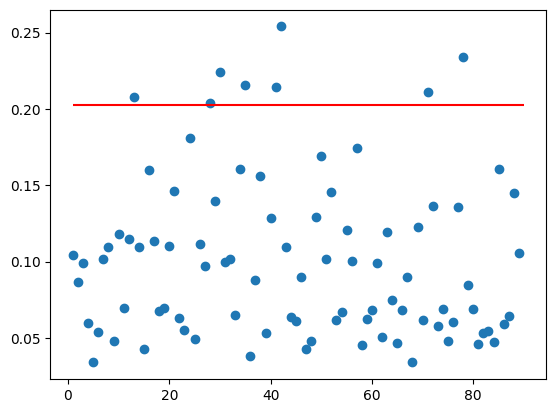

In [25]:
#obserwacje wpływowe - macierz daszkowa
h = fitted_model.get_influence()
h.hat_matrix_diag #macierz daszkowa
threshold = 2*h.exog.shape[1]/h.exog.shape[0]

x = np.arange(1, h.hat_matrix_diag.size + 1)
plt.scatter(x=x, y=h.hat_matrix_diag)
plt.hlines(xmin=1, xmax=h.hat_matrix_diag.size + 1, y=threshold, color="r")

In [26]:
np.where(h.hat_matrix_diag>threshold)[0] #obserwacje wpływowe znalezione za pomocą macierzy daszkowej

array([12, 27, 29, 34, 40, 41, 70, 77])

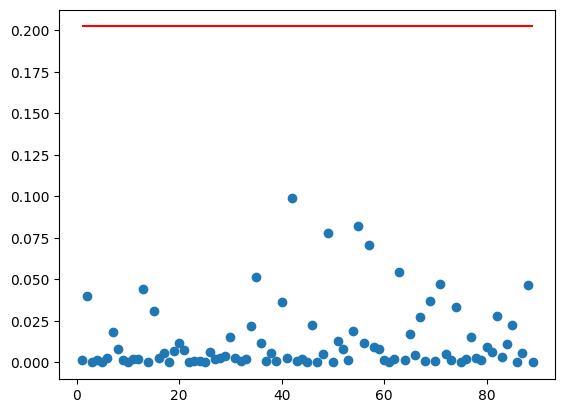

In [27]:
#obserwacje wpływowe - odległości cooka
threshold2 = 4/(h.exog.shape[0]-h.exog.shape[1]-1)
h.cooks_distance #odległości cooka
x = np.arange(1, h.cooks_distance[0].size + 1)
plt.scatter(x=x, y=h.cooks_distance[0])
plt.hlines(xmin=1, xmax = x[-1], y = threshold, color='r')

In [28]:
np.where(h.cooks_distance[0]>threshold2)[0] #obserwacje wpływowe znalezione za pomocą odległości cooka

array([34, 41, 48, 54, 56, 62])

In [31]:
#wpływowe to te wykryte pierwszą i drugą metodą
to_remove = np.intersect1d(np.where(h.hat_matrix_diag>threshold)[0],np.where(h.cooks_distance[0]>threshold2)[0])

In [32]:
to_remove

array([34, 41])

In [33]:
realest2_train = realest_train.copy()

In [34]:
realest2_train = realest2_train.drop(realest2_train.index[to_remove]) #usuwamy obserwacje wpływowe

In [35]:
model2 = smf.ols('Price ~ ' + features, data=realest2_train)
fitted_model2 = model2.fit()
fitted_model2.summary() #delikatna poprawa R^2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     23.39
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           7.89e-18
Time:                        13:37:55   Log-Likelihood:                -284.60
No. Observations:                  87   AIC:                             587.2
Df Residuals:                      78   BIC:                             609.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.0086      5.171      5.029      0.000      15.713      36.304
Bedroom       -4.3546      1.093     -3.985      0.000      -6.530      -2.179
Space          0.0095      0.004      2.199      0.031       0.001       0.018
Room           1.4350      1.293      1.110      0.270      -1.138       4.008
Lot            0.1663      0.109      1.526      0.131      -0.051       0.383
Tax            0.0038      0.004      1.087      0.280      -0.003       0.011
Bathroom       8.4387      2.348      3.595      0.001       3.765      13.112
Garage         3.5737      1.075      3.323      0.001       1.433       5.715
Condition      0.8315      2.074      0.401      0.690      -3.297       4.960
==============================================================================
Omnibus:                        0.073   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.159
Skew:                          -0.066   Prob(JB):                        0.924
Kurtosis:                       2.838   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
h = fitted_model2.get_influence()

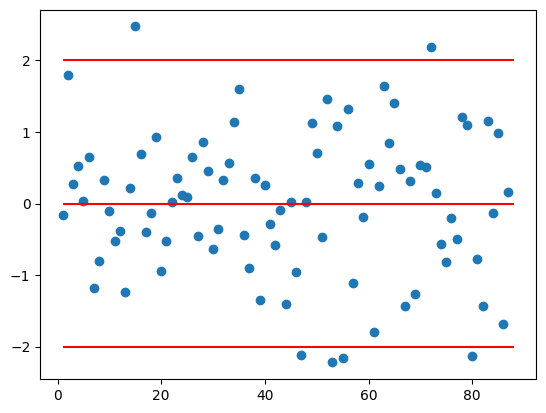

In [37]:
#wartości odstające
x = np.arange(1, h.resid_studentized.size + 1)
plt.scatter(x=x, y=h.resid_studentized) #rezydua studentyzowane
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=-2, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=0, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=2, color="r")

In [38]:
np.where(np.abs(h.resid_studentized)>2)[0] #obs odstające

array([14, 46, 52, 54, 71, 79])

In [39]:
realest3_train = realest2_train.copy()

In [40]:
realest3_train = realest3_train.drop(realest3_train.index[np.where(np.abs(h.resid_studentized)>2)[0] ])

In [41]:
model3 = smf.ols('Price ~ ' + features, data=realest3_train)
fitted_model3 = model3.fit()
fitted_model3.summary() #poprawa R^2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     36.21
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           2.78e-22
Time:                        13:38:25   Log-Likelihood:                -247.49
No. Observations:                  81   AIC:                             513.0
Df Residuals:                      72   BIC:                             534.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.3989      4.461      5.694      0.000      16.507      34.291
Bedroom       -4.3521      0.895     -4.862      0.000      -6.136      -2.568
Space          0.0055      0.004      1.428      0.158      -0.002       0.013
Room           1.2152      1.154      1.053      0.296      -1.086       3.517
Lot            0.0768      0.093      0.826      0.412      -0.108       0.262
Tax            0.0067      0.003      2.148      0.035       0.000       0.013
Bathroom      13.4620      2.127      6.329      0.000       9.222      17.702
Garage         3.2701      0.893      3.664      0.000       1.491       5.049
Condition      1.3861      1.715      0.808      0.422      -2.032       4.804
==============================================================================
Omnibus:                        0.753   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.317
Skew:                          -0.106   Prob(JB):                        0.853
Kurtosis:                       3.222   Cond. No.                     1.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
mean_squared_error(realest_test['Price'],fitted_model3.predict(realest_test))

90.97925586793329

In [43]:
median_absolute_error(realest_test['Price'],fitted_model3.predict(realest_test))

np.float64(5.114447394562305)

In [44]:
realest_test.loc[len(realest_test.index)] = [80, 10, 5000,20,	30,	3000,	4,3, 0]

In [45]:
mean_squared_error(realest_test['Price'],fitted_model3.predict(realest_test)) #mocny wzrost, duży wpływ outliera

127.46927727048686

In [46]:
median_absolute_error(realest_test['Price'],fitted_model3.predict(realest_test)) #mały wzrost (mediana i wartości bezwzględne bardziej odporne na outliery)

np.float64(5.238231149360153)